<h1>[dstl] Satellite Imagery Feature Detection Project</h1>

Project is done as part of the <a href="https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/kernels"> [dstl] Satellite Imagery Feature Detection </a> Kaggle Competition. This work seeks to better understand how to do semantic segmentation (a category of Computer Vision) in Python. Work is inspired by the great kernels from participants of this competition. See the Github "ReadMe" for a list of kernels inspired from.
<h2>Data</h2>
As the image dataset was given in GeoTiff format, we required the use of tifffile and matplotlib to visualize them. In the same way, As the training WKT gave the information as MultipolygonWKT, we needed shapely (or geopandas) to keep track of the geometric form of the polygon classes.

In [1]:
import csv
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
from matplotlib.patches import Polygon as polyg

In [2]:
import tifffile as tiff
from shapely.wkt import loads
import shapely
from shapely.geometry import MultiPolygon, Polygon
import shapely.affinity
import shapely.wkt
from collections import defaultdict
#from PIL import Image

In [3]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import average_precision_score
import skimage
from skimage.feature import greycomatrix, greycoprops
from skimage.filters import sobel

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
%matplotlib inline

<h2>Lists and variables </h2>

Because the dataset we are working with in this project is fairly large, the following cell is needed to not get a "field larger than field limit" Error when using the csv module.

In [6]:
#to load large files
maxInt = sys.maxsize
decrement = True

while decrement:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.
    decrement = False
    try:
        csv.field_size_limit(maxInt)
    except OverflowError:
        maxInt = int(maxInt/10)
        decrement = True

The following dictionaries map the class numerical value to its filename. ClassType can be found in the train_wkt.csv document.

In [7]:
CLASSES = {
    1 : 'Bldg',
    2 : 'Struct',
    3 : 'Road',
    4 : 'Track',
    5 : 'Trees',
    6 : 'Crops',
    7 : 'Fast H20',
    8 : 'Slow H20',
    9 : 'Truck',
    10 : 'Car'
}
filename_to_classType = {
    '001_MM_L2_LARGE_BUILDING': 1,
    '001_MM_L3_RESIDENTIAL_BUILDING': 1,
    '001_MM_L3_NON_RESIDENTIAL_BUILDING': 1,
    '001_MM_L5_MISC_SMALL_STRUCTURE': 2,
    '002_TR_L3_GOOD_ROADS': 3,
    '002_TR_L4_POOR_DIRT_CART_TRACK': 4,
    '002_TR_L6_FOOTPATH_TRAIL': 4,
    '006_VEG_L2_WOODLAND': 5,
    '006_VEG_L3_HEDGEROWS': 5,
    '006_VEG_L5_GROUP_TREES': 5,
    '006_VEG_L5_STANDALONE_TREES': 5,
    '007_AGR_L2_CONTOUR_PLOUGHING_CROPLAND': 6,
    '007_AGR_L6_ROW_CROP': 6, 
    '008_WTR_L3_WATERWAY': 7,
    '008_WTR_L2_STANDING_WATER': 8,
    '003_VH_L4_LARGE_VEHICLE': 9,
    '003_VH_L5_SMALL_VEHICLE': 10,
    '003_VH_L6_MOTORBIKE': 10
}

<h2>Loading the dataset</h2>

Here, we are loading our datasets (both the training and the grid sizes files as pandas dataframes). The column name is changed such that ImageId becomes the common key between the two tables.

In [8]:
grid_sizes = pd.read_csv('./input/grid_sizes.csv')
grid_sizes.rename(columns={'Unnamed: 0':'ImageId'}, inplace=True)
grid_sizes.head()

ImageId      Xmax     Ymin
0  6120_2_4  0.009180 -0.00904
1  6120_2_3  0.009169 -0.00904
2  6120_2_2  0.009188 -0.00904
3  6120_2_1  0.009188 -0.00904
4  6120_2_0  0.009188 -0.00904

In [9]:
wkt_v4 = pd.read_csv('./input/train_wkt_v4.csv')
wkt_df = pd.read_csv('./input/train_wkt_v4.csv')
wkt_df.loc[wkt_df.MultipolygonWKT =='MULTIPOLYGON EMPTY','MultipolygonWKT'] = np.nan
wkt_df = wkt_df[wkt_df.MultipolygonWKT != 'MULTIPOLYGON EMPTY']
wkt_df.head()

ImageId  ClassType                                    MultipolygonWKT
0  6040_2_2          1                                                NaN
1  6040_2_2          2                                                NaN
2  6040_2_2          3                                                NaN
3  6040_2_2          4  MULTIPOLYGON (((0.003025 -0.007879000000000001...
4  6040_2_2          5  MULTIPOLYGON (((0.005311 -0.009044999999999999...

In [10]:
#Define the variables we care about in this study
allImageIds = grid_sizes.ImageId.unique()
allClassTypes = wkt_df.ClassType.unique()
unique_set_ImageIds = grid_sizes.ImageId.astype(str).str[0:4].unique()
ImageId = '6120_2_2'
Poly_class = 1 #np.asscalar(allClassTypes[0])

In [11]:
#this is a common function that will be called often later to redeclare the variables when needed
def variables(ImageId, Poly_class):
    global rgb, im_rgb, x_max, y_min, train_polygons
    rgb = tiff.imread('./data/three_band/{}.tif'.format(ImageId))
    im_rgb = tiff.imread('./data/three_band/{}.tif'.format(ImageId)).transpose([1, 2, 0])
    x_max = y_min = None
    for i, row in grid_sizes.iterrows():
        if row['ImageId'] == '6120_2_2':
            x_max, y_min = float(row['Xmax']), float(row['Ymin'])
            break
    train_polygons = None
    for i, row in wkt_v4.iterrows():
        if row['ImageId'] == '6120_2_2' and row['ClassType'] == Poly_class:
            train_polygons = loads(row['MultipolygonWKT'])
            break

In [12]:
variables(ImageId, Poly_class)

<h2>Visualizing</h2>

The most classic way to visualize a satellite image is to simply plot it using the tifffine module.

(<matplotlib.figure.Figure at 0x1fd9c42c320>,
 <matplotlib.image.AxesImage at 0x1fd9ef30cc0>)

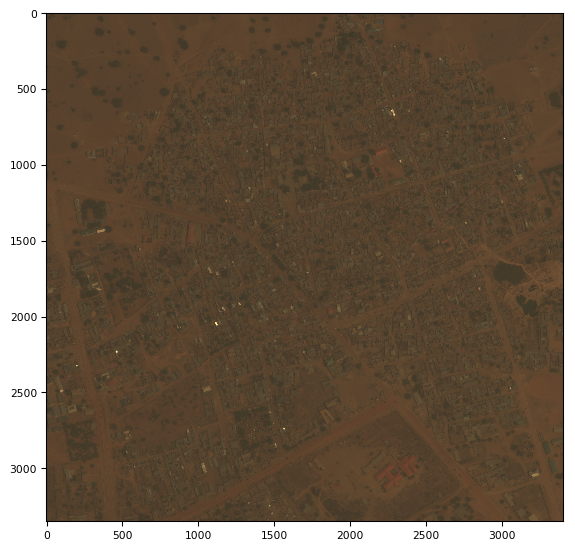

In [13]:
tiff.imshow(im_rgb)

However a way better way to visualize the satellite image is by changing the pixel value of images into 5 to 95%, which is a robust way to eliminate the outlier pixel coloring.

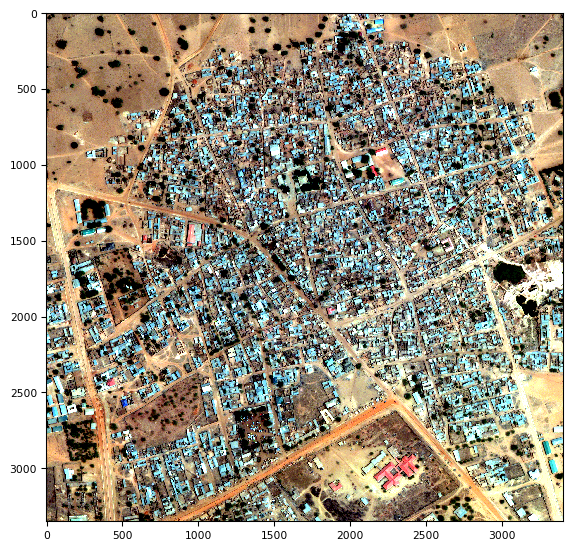

In [14]:
def scale_percentile(matrix):
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 5nd and 95th percentile
    mins = np.percentile(matrix, 6, axis=0)
    maxs = np.percentile(matrix, 94, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix
tiff.imshow(255*scale_percentile(im_rgb)); #choosing size

<h2> Some Data Analytics on the Dataset"</h2>

In [15]:
# PolygonList is the list of all classes inside the image with its MultipolygonWKT values
polygonsList = {}
image = wkt_v4[wkt_df.ImageId == ImageId]
for cType in image.ClassType.unique():
    polygonsList[cType] = loads(image[image.ClassType == cType].MultipolygonWKT.values[0])

In [16]:
# number of objects on the image by type
for p in polygonsList:
    print("Class type: [{}] {} -> Number of objects: {}".format(p, CLASSES[p],len(polygonsList[p].geoms)))

Class type: [1] Bldg -> Number of objects: 1962
Class type: [2] Struct -> Number of objects: 3201
Class type: [3] Road -> Number of objects: 1
Class type: [4] Track -> Number of objects: 33
Class type: [5] Trees -> Number of objects: 1452
Class type: [6] Crops -> Number of objects: 20
Class type: [7] Fast H20 -> Number of objects: 0
Class type: [8] Slow H20 -> Number of objects: 6
Class type: [9] Truck -> Number of objects: 9
Class type: [10] Car -> Number of objects: 548


In [17]:
# Do the same as previously but for all existing ImageId identified by the training WKT
# Below is a pivot table where the columns are class types and the rows are for each ImageId
wkt_v4['polygons'] = wkt_v4.apply(lambda row: loads(row.MultipolygonWKT),axis=1)
wkt_v4['nPolygons'] = wkt_v4.apply(lambda row: len(row['polygons'].geoms),axis=1)
pvt = wkt_v4.pivot(index='ImageId', columns='ClassType', values='nPolygons')
pvt

ClassType    1     2   3   4     5   6   7   8   9    10
ImageId                                                 
6010_1_2      0    44   0  12  1733   0   0   0   0    0
6010_4_2      0     0   0   6  2262   0   0   0   0    0
6010_4_4      0     0   0   0  3860   0   0   0   0    0
6040_1_0      0     0   0   5  2446   0   0   0   0    0
6040_1_3      0     0   0   1  3982   2   0   0   0    0
6040_2_2      0     0   0   2  3879   0   0   0   0    0
6040_4_4      0     0   0   7  1901   0   0   0   0    0
6060_2_3     62   173   0   7  1613  86   0   0   0    1
6070_2_3    109    81   2   0    41   0  24   3   0   13
6090_2_0      0    11   0   3  2308   7   0  19   0    1
6100_1_3   2208  1581   1  13   823   3   0   4  11  129
6100_2_2    633   454   1  27   878  11   4   1  13  101
6100_2_3   1690  1226   2  24   574   0   0   2  14  126
6110_1_2   1584  1420   1  10   855  28   0  63   0   23
6110_3_1    581   706   1  19  1239  35   0   9   3   25
6110_4_0    437   502   2  11  1406  29   0  24   7   13
6120_2_0    573  1193   1   4  1542  67   0   0   6   11
6120_2_2   1962  3201   1  33  1452  20   0   6   9  548
6140_1_2   1607  1111   1   9   817  27   0  75   0   23
6140_3_1    565   563   1  19  1110  37   0   9   3   46
6150_2_3      0    47   0   4  2060  68   0   0   0    0
6160_2_1      0     0   0   8  2432   0   0   0   0    0
6170_0_4      0     1   0   9  2774   0   0   8   0    0
6170_2_4      0     1   0   4  2115   2   0   1   0    0
6170_4_1      0     0   0   2  4245   0   0   0   0    0

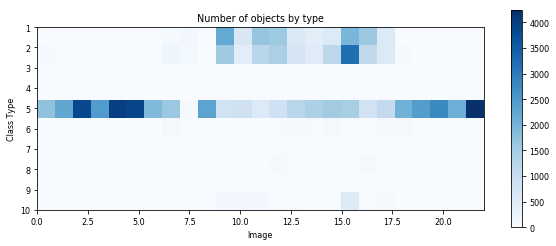

In [18]:
#Heatmap for the frequency of class types
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_aspect('equal')
plt.imshow(pvt.T, interpolation='nearest', cmap=plt.cm.Blues, extent=[0,22,10,1])
plt.yticks(np.arange(1, 11, 1.0))
plt.title('Number of objects by type')
plt.ylabel('Class Type')
plt.xlabel('Image')
plt.colorbar()
plt.show()

For this dataset, we see that the trees (having classtype 5) is the most identified object type for the labeled images. The dataset we got represents satellite images of 1km X 1km rural and urban areas. If you go check our second kernel where we visualized 7 different channels, we can see that trees and natural elements are dominating in most satellite images. The other major class types represented in the satellite images are buildings and vehicles. Waterways and routes are present at much smaller scale.

<h2>Show Polygon Masks</h2>
To help with the training of the dataset, some of the satellite has their polygon classes labelled in shapely multipolygon format. This implies that for specific satellite images, we can visualize it using Polygon masks. Three different methods are presented below.

In [19]:
def show_mask(m):
    # hack for nice display
    tiff.imshow(255 * np.stack([m, m, m]));

<h3>Visualizing the Polygons Method 1: Using matplotlib.patches.Polygon</h3>
The matplotlib.patches.Polygon returns a general polygon patch which can be plotted.

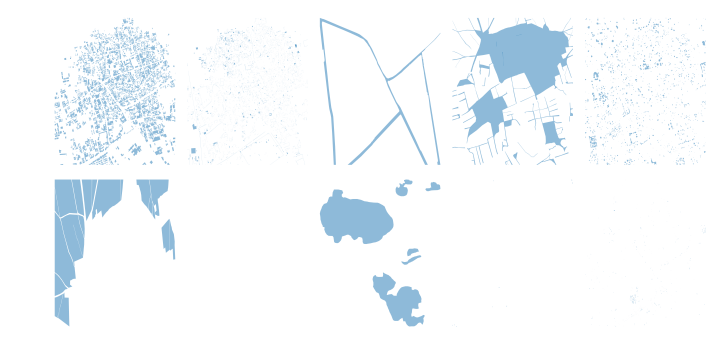

In [20]:
# plotting by class type (p variable)
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i, p in enumerate(polygonsList):
    if i<5:
        for polygon in polygonsList[p]:
            #color=plt.cm.Set1(p*10)
            mpl_poly = polyg(np.array(polygon.exterior), lw=5, alpha=0.5)
            ax[0, i].add_patch(mpl_poly)
        ax[0, i].relim()
        ax[0, i].autoscale_view()
        ax[0, i].axis('off')
    else:
        for polygon in polygonsList[p]:
            #color=plt.cm.Set1(p*10)
            mpl_poly = polyg(np.array(polygon.exterior), lw=5, alpha=0.5)
            ax[1, i-5].add_patch(mpl_poly)
        ax[1, i-5].relim()
        ax[1, i-5].autoscale_view()
        ax[1, i-5].axis('off')
plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

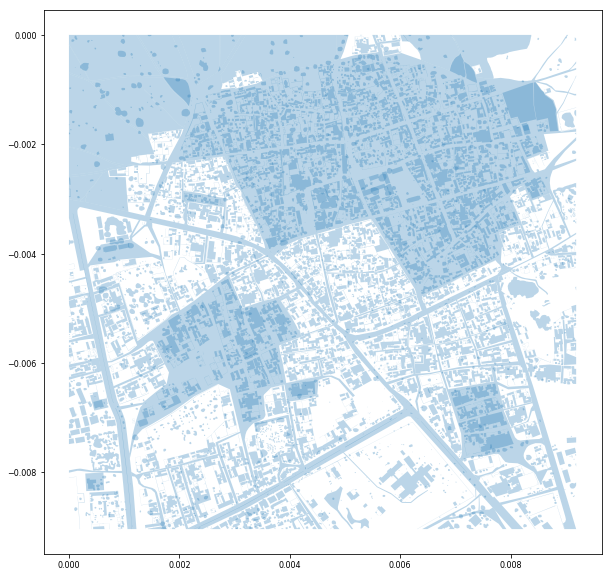

In [21]:
# plot all the polygons on top of each other using matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
# plotting, color by class type (p variable)
for i, p in enumerate(polygonsList):
    for polygon in polygonsList[p]:
        #color=plt.cm.Set1(p*10)
        mpl_poly = polyg(np.array(polygon.exterior), lw=0, alpha=0.3)
        ax.add_patch(mpl_poly)
    ax.relim()
    ax.autoscale_view()
fig.subplots_adjust(wspace=0, hspace=0)

<h3>Visualizing the Polygons Method 2: Using OpenCV.fillPoly to Fill</h3>

In [22]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    Xmax,Ymax = xymax
    H,W = img_size
    W1 = 1.0*W*W/(W+1)
    H1 = 1.0*H*H/(H+1)
    xf = W1/Xmax
    yf = H1/Ymax
    coords[:,1] *= yf
    coords[:,0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

def _get_xmax_ymin(grid_sizes_panda, imageId):
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0,1:].astype(float)
    return (xmax,ymin)

def _get_polygon_list(wkt_list_pandas, imageId, cType):
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = loads(multipoly_def.values[0])
    return polygonList

def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list,interior_list

def _plot_mask_from_contours(raster_img_size, contours, class_value = 1):
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list,interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask

def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda, wkt_list_pandas):
    xymax = _get_xmax_ymin(grid_sizes_panda,imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas,imageId,class_type)
    contours = _get_and_convert_contours(polygon_list,raster_size,xymax)
    mask = _plot_mask_from_contours(raster_size,contours,1)
    return mask

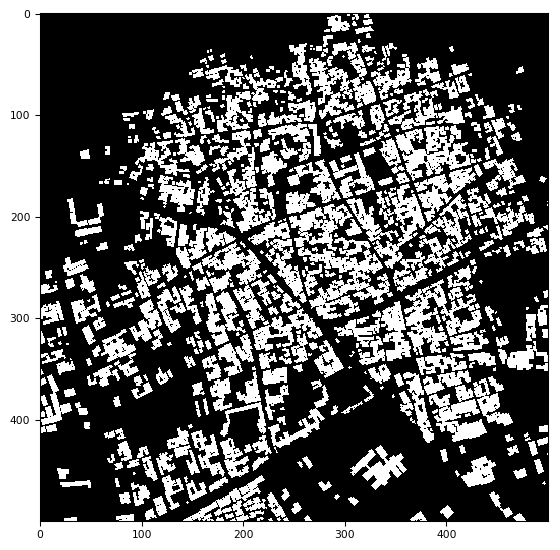

In [23]:
# Visualizing for one polygon class, notice that 1 is for buildings
mask = generate_mask_for_image_and_class((500,500), ImageId, 1, grid_sizes, wkt_v4)
show_mask(mask)

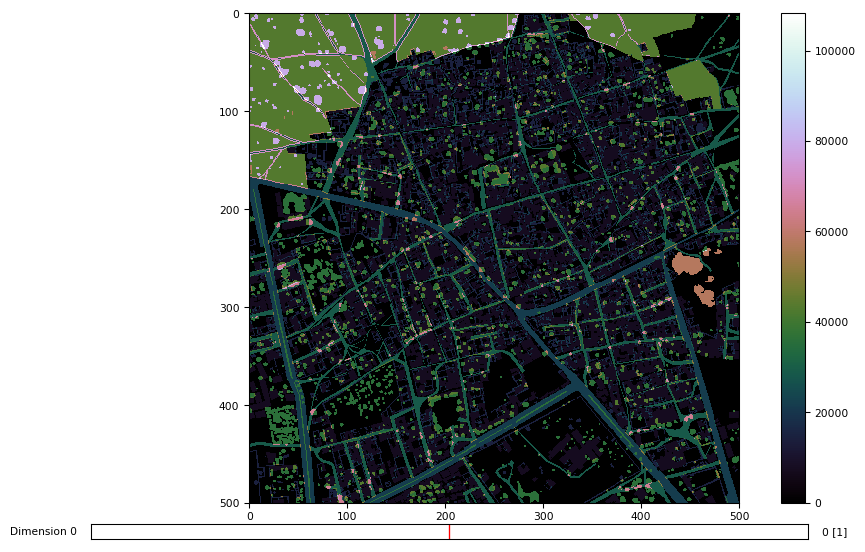

In [24]:
#combine all the polygon masks together
set_of_mask = dict()
mask_test = np.zeros((500, 500))
for i in range(0,9):
    mask = generate_mask_for_image_and_class((500,500), ImageId, i , grid_sizes, wkt_v4)
    set_of_mask[i] =  mask*255/9*i
    mask_test = mask_test + mask*255/9*i
x = tiff.imshow(255 * mask_test)

<h3>Visualizing the Polygons Method 3: Using OpenCV.polylines to Render</h3>

In [25]:
def adjust_contrast(x):    
    for i in range(3):
        x[:,:,i] = stretch2(x[:,:,i])
    return x.astype(np.uint8)

def stretch2(band, lower_percent=2, higher_percent=98):
    a = 0 #np.min(band)
    b = 255  #np.max(band)
    c = np.percentile(band, lower_percent)
    d = np.percentile(band, higher_percent)        
    out = a + (band - c) * (b - a) / (d - c)    
    out[out<a] = a
    out[out>b] = b
    return out

In [26]:
def truth_polys(image_id, class_id, W, H):
    rows = wkt_df.loc[(wkt_df.ImageId==image_id) & (wkt_df.ClassType==class_id), 'MultipolygonWKT']
    mp = loads(rows.values[0])
    xmax, ymin = grid_sizes[grid_sizes.ImageId == ImageId].iloc[0,1:].astype(float)    
    W_ = W * (W/(W+1.))
    H_ = H * (H/(H+1.))
    x_scaler = W_ / xmax
    y_scaler = H_ / ymin
    return shapely.affinity.scale(mp, xfact = x_scaler, yfact= y_scaler, origin=(0,0,0))  

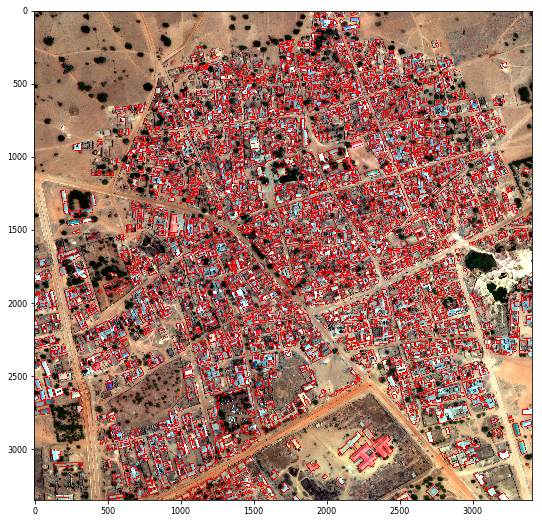

In [27]:
rgb = tiff.imread('./data/three_band/{}.tif'.format(ImageId))
rgb = np.rollaxis(rgb, 0, 3)
x = adjust_contrast(rgb).copy()
H=len(x); W=len(x[0])
#Read Polygons
polys = truth_polys(ImageId, Poly_class, W, H)
int_vertices=lambda x: np.array(x).round().astype(np.int32)
for poly_id, poly in enumerate(polys):
    xys=int_vertices(poly.exterior.coords)
    cv2.polylines(x,[xys],True,(255,0,0),3)
    for pi in poly.interiors:
        ixys=int_vertices(pi.coords)
        cv2.polylines(x,[ixys],True,(255,0,0),3)   
#Plot
fig, ax = plt.subplots(figsize=(9,9))
ax.imshow(x)

<h3>Bonus: Visualize the whole satellite channel together!</h3>
As a bonus, we defined functions to visualize the whole channel's 25 satellite images together. We also wrote a different Jupyter notebook doing exactly that for many different channels.

In [28]:
def plot_5_by_5(list_of_id):
    fig, ax = plt.subplots(5, 5, figsize=(20, 20))
    for k in list_of_id:
        i = int(k[5])
        j = int(k[7])
        temp = tiff.imread('./data/three_band/{}.tif'.format(k))
        temp = np.rollaxis(temp, 0, 3)
        y = adjust_contrast(temp).copy()
        ax[i, j].imshow(y)
        ax[i, j].axis('off')
    fig.subplots_adjust(wspace=0, hspace=0)

Wall time: 55.1 s


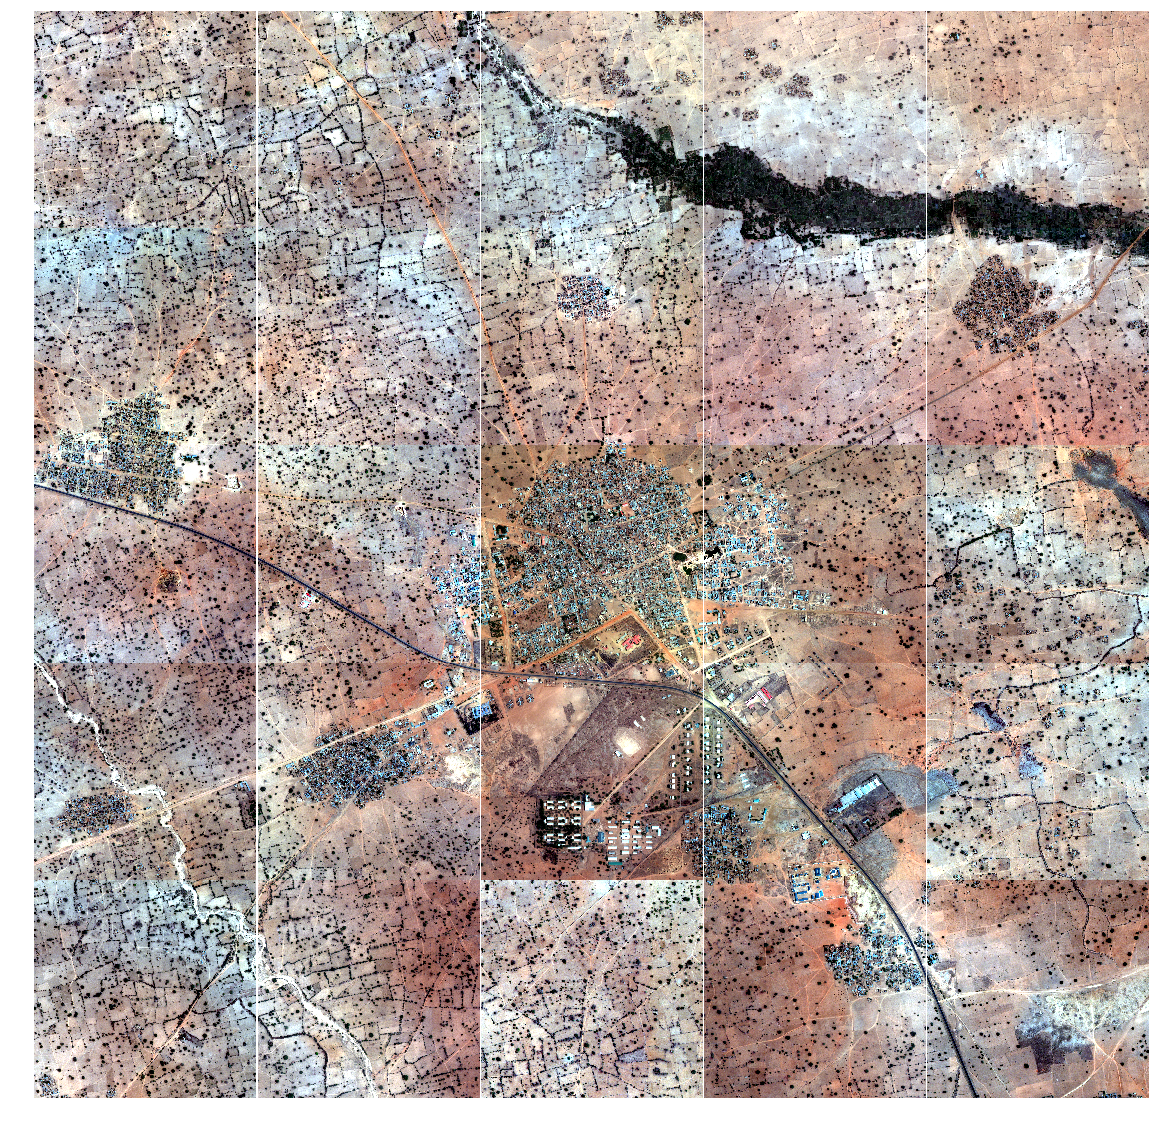

In [29]:
%%time
#plot all images: plot 5 images (top and bottom of the image we are studying)
temp_set_id = ImageId[0:4]
list_of_id = []
for i in allImageIds:
    if i[0:4] == temp_set_id:
        list_of_id.append(i)
plot_5_by_5(list_of_id)

<h2>Prediction: Logistic regression classifier</h2>
In the context of this project, we have labeled training set data. It hence makes sense to use a supervised machine learning algorithm to do the prediction. Although Computer Vision has benefitted extensively from the advancement of Deep Learning and its libraries (TensorFlow, Keras, CNN, etc), we decided to follow the simpler method introduced on the Kaggle competition kernel. Hence a logistic regression classifier that takes as input the values of the multipolygon from the training WKT to was used to do the prediction.
<h3>Train dataset</h3>

In [30]:
#scale the image
def get_scalers():
    h, w = im_rgb.shape[:2]  # they are flipped so that mask_for_polygons works correctly
    w_ = w * (w / (w + 1))
    h_ = h * (h / (h + 1))
    return w_ / x_max, h_ / y_min

In [31]:
#create a mask from polygons
def mask_for_polygons(polygons):
    img_mask = np.zeros(im_rgb.shape[:2], np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

In [32]:
x_scaler, y_scaler = get_scalers()
train_polygons_scaled = shapely.affinity.scale(train_polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))
train_mask = mask_for_polygons(train_polygons_scaled)

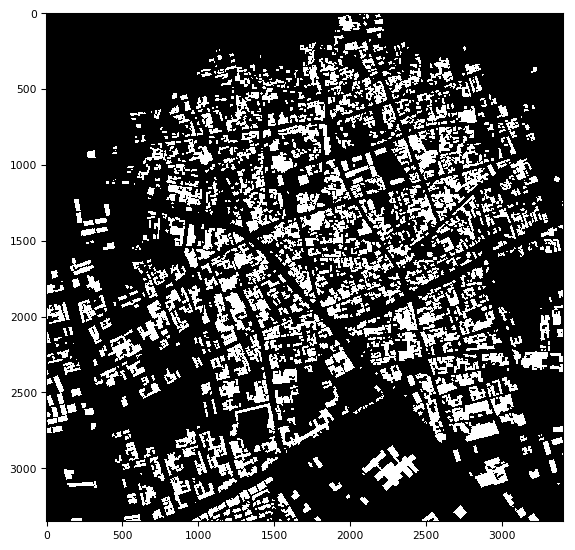

In [33]:
#Get the binary image
show_mask(train_mask)

In [34]:
xs = im_rgb.reshape(-1, 3).astype(np.float32)
ys = train_mask.reshape(-1)
pipeline = make_pipeline(StandardScaler(), SGDClassifier(loss='log'))

print('training...')
# do not care about overfitting here
pipeline.fit(xs, ys)
pred_ys = pipeline.predict_proba(xs)[:, 1]
print('average precision', average_precision_score(ys, pred_ys))
pred_mask = pred_ys.reshape(train_mask.shape)

training...
average precision 0.825796031017


<h3>Test Images</h3>

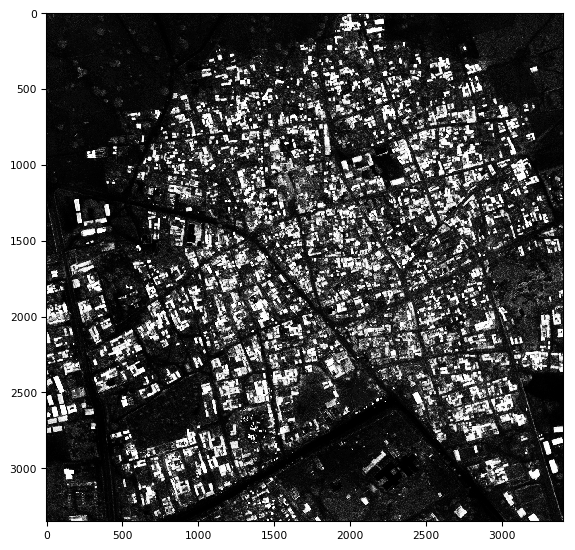

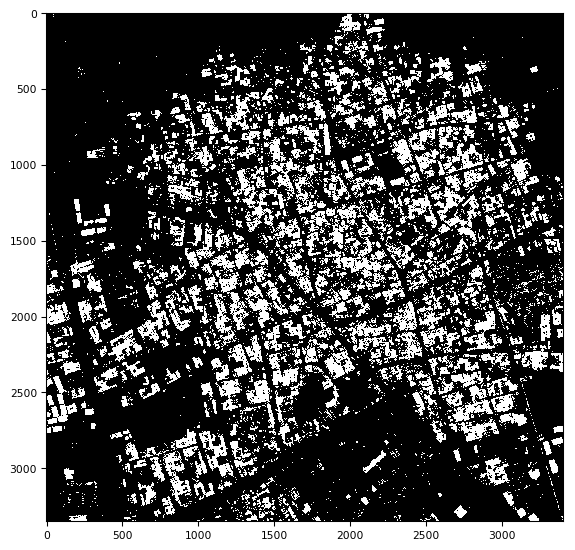

In [35]:
# Predicted mask
show_mask(pred_mask)
# Predicted mask with threshold
threshold = 0.3
pred_binary_mask = pred_mask >= threshold
show_mask(pred_binary_mask)

Pixel jaccard 0.594350726525


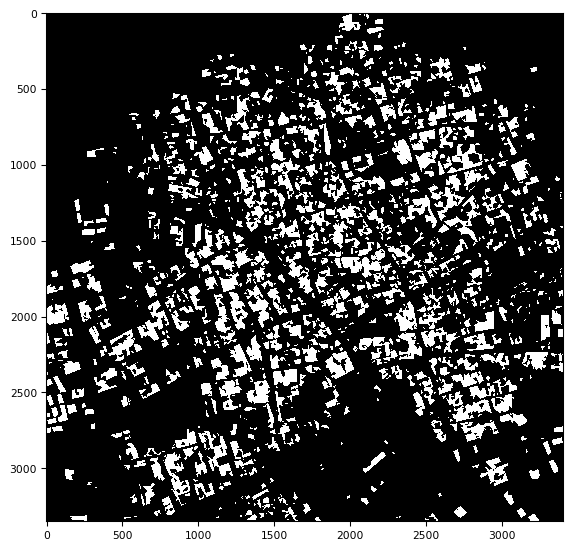

In [36]:
#create polygons from bit masks
def mask_to_polygons(mask, epsilon=10., min_area=10.):
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(-1)
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

#Rendering Shapes: Jaccard on the pixel level
tp, fp, fn = (( pred_binary_mask &  train_mask).sum(),
              ( pred_binary_mask & ~train_mask).sum(),
              (~pred_binary_mask &  train_mask).sum())
print('Pixel jaccard', tp / (tp + fp + fn))
#prediction to polygon and back to mask! This shows that the shapes has been rendered!
pred_polygons = mask_to_polygons(pred_binary_mask)
pred_poly_mask = mask_for_polygons(pred_polygons)
show_mask(pred_poly_mask)

<h2>Visualize the whole channel's prediction</h2>
The excellent result can be explained by the allowance of overfitting. Indeed, in this case, we were looking at the file "6120_2_2" which is a labeled geotiff file. It hence becomes important to retest the algorithm on cases where the multipolygon values were not defined. This is done for all files in the channel "6120". <br><br>
As we can see below, the prediction values become a lot lower, averaging 25%. Although disappoint, it makes sense because the dataset given to do the training had most of the images unlabeled and each satellite image depends on multiple geographical factors and the 2D rendered masks changes accordingly. In fact, out of 450 satellite images in our dataset, only 25 of them were properly labeled for training. Maybe using CNN could result in better result.

In [37]:
def plot_5_by_5_pred(list_of_id, list_of_img):
    fig, ax = plt.subplots(5, 5, figsize=(20, 20))
    n = len(list_of_id)
    for i in range(0, n):
        ax[int(list_of_id[i][5]), int(list_of_id[i][7])].imshow(list_of_img[i])
        ax[int(list_of_id[i][5]), int(list_of_id[i][7])].axis('off')
    fig.subplots_adjust(wspace=0, hspace=0)

In [38]:
def predicting_values(im_ID):
    variables(im_ID, Poly_class)
    x_scaler, y_scaler = get_scalers()
    train_polygons_scaled = shapely.affinity.scale(train_polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))
    train_mask = mask_for_polygons(train_polygons_scaled)
    xs = im_rgb.reshape(-1, 3).astype(np.float32)
    ys = train_mask.reshape(-1)
    pipeline = make_pipeline(StandardScaler(), SGDClassifier(loss='log'))
    # overfitting is not considered
    pipeline.fit(xs, ys)
    pred_ys = pipeline.predict_proba(xs)[:, 1]
    print('training average precision for {} is {}'.format(im_ID, average_precision_score(ys, pred_ys)))
    pred_mask = pred_ys.reshape(im_rgb.shape[:2])
    # Predicted mask with threshold into binary image
    threshold = 0.3
    pred_binary_mask = pred_mask >= threshold
    return pred_binary_mask

In [39]:
%%time
#plot all images: plot 5 images (top and bottom of the image we are studying)
temp_set_id = '6120'
list_of_id = []
list_of_img = []
for i in allImageIds:
    if i[0:4] == temp_set_id:
        x = predicting_values(i)
        list_of_id.append(i)
        list_of_img.append(x)

training average precision for 6120_2_4 is 0.24657515946888459
training average precision for 6120_2_3 is 0.23138558701766013
training average precision for 6120_2_2 is 0.8324162715424217
training average precision for 6120_2_1 is 0.23847124354217705
training average precision for 6120_2_0 is 0.2639197546307146
training average precision for 6120_1_0 is 0.25139371433080865
training average precision for 6120_1_1 is 0.26011753241205166
training average precision for 6120_1_2 is 0.23393573086951125
training average precision for 6120_1_3 is 0.2429280143136694
training average precision for 6120_1_4 is 0.22550117069147266
training average precision for 6120_3_4 is 0.23259781072395275
training average precision for 6120_3_2 is 0.23027068040537227
training average precision for 6120_3_3 is 0.23420832384807005
training average precision for 6120_3_0 is 0.23342345602763317
training average precision for 6120_3_1 is 0.24125744609018251
training average precision for 6120_4_4 is 0.2456747167982

Wall time: 2.97 s


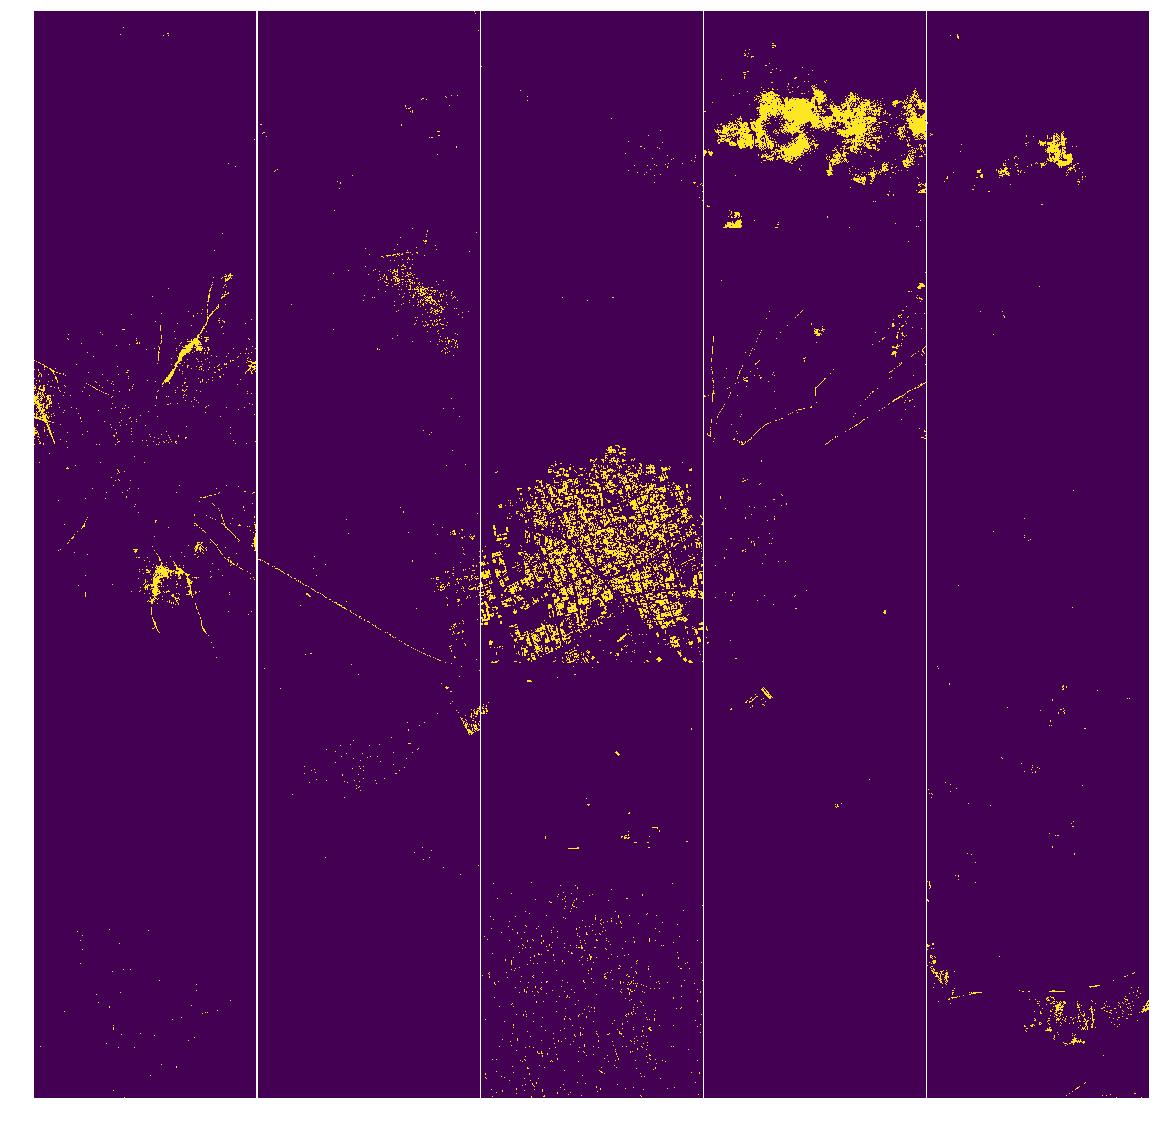

In [40]:
%%time
plot_5_by_5_pred(list_of_id, list_of_img)